**3rd Assignment - Pengolahan Citra Digital** <br>
**Farsya Nabila Tori [24/543855/PA/23113] - KOM**

*Implement one of the segmentation methods and several operation of morphological methods without using library.
Comparing the segmentation result with and without applying morphological processing.*

##Morphological Processing


Proses Morfologi adalah tahap yang dilakukan untuk memperbaiki atau meningkatkan kualitas dari suatu citra hasil segmentasi. Proses ini menggunakan *Structuring Element (SE)* atau kernel sebagai input untuk menguji dan mengubah bentuk region piksel. Ada empat operasi morfologis sederhana yang akan dilakukan, yakni <br>
**(1) Erosi:** untuk pengikisan/pengecilan area *foreground*, *region separation, noise removal*, dan cenderung menggelapkan citra *grayscale.* <br>
**(2) Dilasi:** untuk perluasan/pembesaran area *foreground*, *region merging, holes filling*, dan cenderung mencerahkan citra *grayscale.* <br> <br>
Lalu, dengan ukuran dan jenis SE atau kernel yang sama, dapat dilakukan operasi morfologis berupa <br>
**(3) Opening:** Erosi + Dilasi, yang fungsinya mirip dengan erosi, yaitu untuk menghilangkan noise bintik kecil dari *foreground* (kurang destruktif terhadap *boundary* dibandingkan erosi murni).<br>
**(4) Closing:** Dilasi + Erosi, yang fungsinya mirip dengan dilasi, yaitu untuk mengisi lubang kecil di *foreground*, tetapi cenderung digunakan untuk metode segmentasi berbasis ROI *(Region of Interest).* <br>


###Proses Segmentasi

Digunakan gambar hasil *scan* tulisan tangan sebagai berikut karena terdapat karakteristik berupa tulisan (piksel gelap) di atas kertas putih (piksel terang) sehingga analisis metode segmentasi yang digunakan dapat dilakukan lebih mudah. <br> <br> ![handwritten-sample](https://drive.google.com/uc?id=1faqZc_w73x0UYETr-zyOw6zhn66C6Jas)

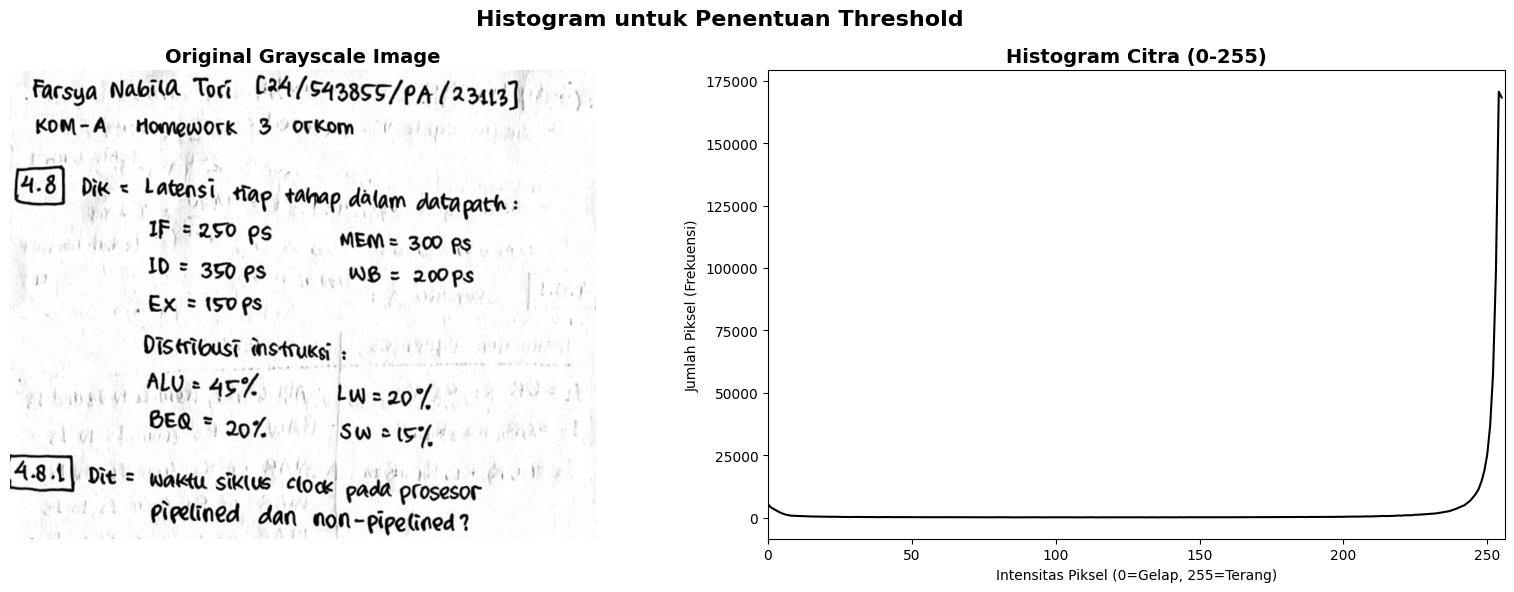

In [ ]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt

image_url = 'https://drive.google.com/uc?id=1faqZc_w73x0UYETr-zyOw6zhn66C6Jas'
def url_to_image(url):
    try:
        resp = requests.get(url, stream=True).raw
        image = np.asarray(bytearray(resp.read()), dtype=np.uint8)
        img = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

original_color = url_to_image(image_url)
if original_color is not None:
    image_grayscale = cv2.cvtColor(original_color, cv2.COLOR_BGR2GRAY)
    hist_values = cv2.calcHist([image_grayscale], [0], None, [256], [0, 256])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].imshow(image_grayscale, cmap='gray')
    axes[0].set_title('Original Grayscale Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    axes[1].plot(hist_values, color='black')
    axes[1].set_title('Histogram Citra (0-255)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Intensitas Piksel (0=Gelap, 255=Terang)')
    axes[1].set_ylabel('Jumlah Piksel (Frekuensi)')
    axes[1].set_xlim([0, 256])
    plt.suptitle('Histogram untuk Penentuan Threshold', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

Di atas dilakukan segmentasi dengan metode Global Thresholding dengan memvisualisasikan histogram terkait untuk penentuan Threshold-nya. Berdasarkan histogram, dipilih T = 150 untuk memisahkan puncak kecil di dekat 0 dan puncak yang sangat besar di dekat 255. T = 150 dipilih karena terletak di kisaran abu-abu menengah dan memastikan piksel tinta yang tipis atau pudar tetap tertangkap. Hasilnya adalah sebagai berikut.

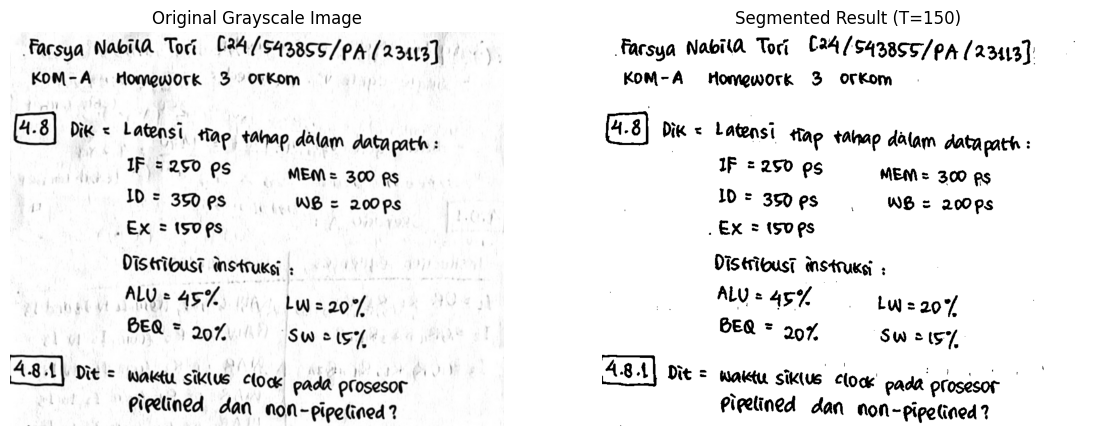

In [ ]:
def manual_thresholding(image_gray, T):
    binary_image = np.zeros_like(image_gray, dtype=np.uint8)
    rows, cols = image_gray.shape

    for i in range(rows):
        for j in range(cols):
            if image_gray[i, j] >= T:
                binary_image[i, j] = 255
            else:
                binary_image[i, j] = 0
    return binary_image

if original_color is not None:
    image_grayscale = cv2.cvtColor(original_color, cv2.COLOR_BGR2GRAY)
    T_value = 150
    global_segmented_result = manual_thresholding(image_grayscale, T_value)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].imshow(image_grayscale, cmap='gray')
    axes[0].set_title('Original Grayscale Image')
    axes[0].axis('off')
    axes[1].imshow(global_segmented_result, cmap='gray')
    axes[1].set_title(f'Segmented Result (T={T_value})')
    axes[1].axis('off')
    plt.show()

Selain dengan metode Global Thresholding, dilakukan pula segmentasi dengan metode Otsu yang menjadikan teks (warna putih) secara lebih baik terpisah dari background (hitam pekat).

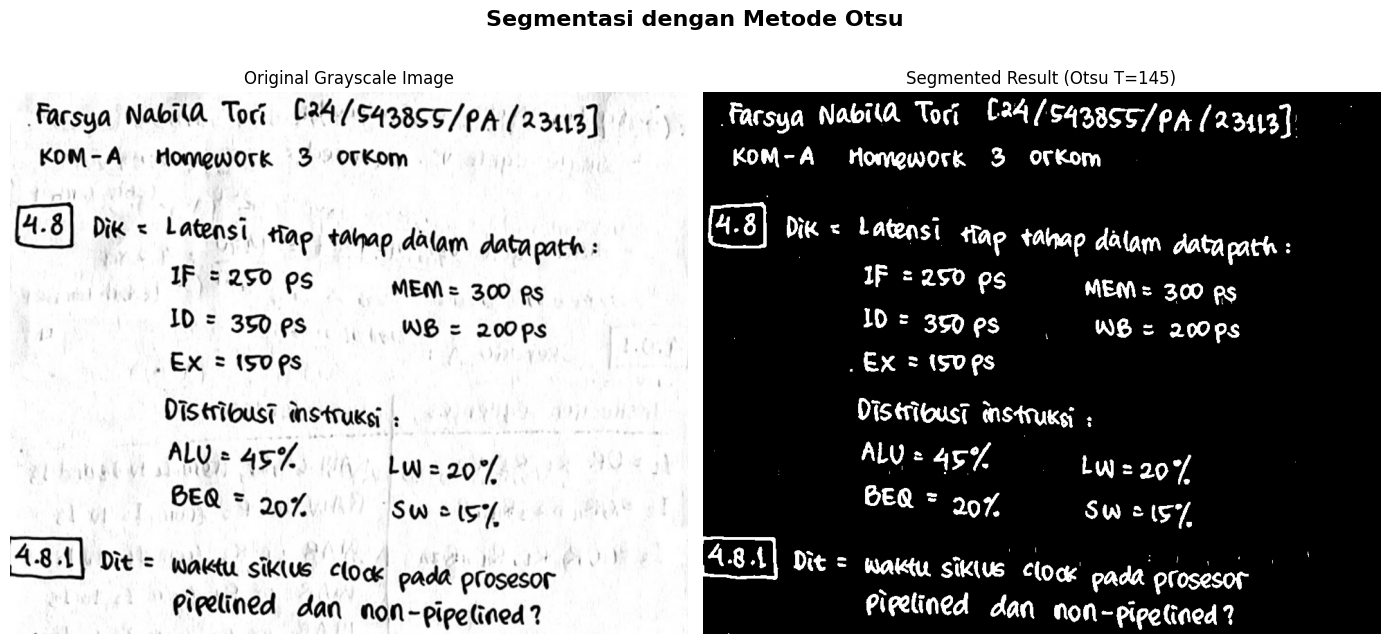

In [ ]:
def find_otsu_threshold(image_gray):
    hist, bins = np.histogram(image_gray.flatten(), 256, [0, 256])
    total_pixels = image_gray.size
    probabilities = hist / total_pixels
    global_mean = np.sum(probabilities * np.arange(256))

    max_between_variance = 0
    optimal_T = 0
    for T in range(1, 255):
        prob_class1 = np.sum(probabilities[:T])
        prob_class2 = np.sum(probabilities[T:])

        if prob_class1 == 0 or prob_class2 == 0:
            continue
        mean_class1 = np.sum(probabilities[:T] * np.arange(T)) / prob_class1
        mean_class2 = np.sum(probabilities[T:] * np.arange(T, 256)) / prob_class2
        between_variance = prob_class1 * prob_class2 * (mean_class1 - mean_class2)**2

        if between_variance > max_between_variance:
            max_between_variance = between_variance
            optimal_T = T
    return optimal_T

if original_color is not None:
    image_grayscale = cv2.cvtColor(original_color, cv2.COLOR_BGR2GRAY)
    T_optimal = find_otsu_threshold(image_grayscale)
    otsu_segmented_result = manual_thresholding_ink(image_grayscale, T_optimal)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    axes[0].imshow(image_grayscale, cmap='gray')
    axes[0].set_title('Original Grayscale Image')
    axes[0].axis('off')
    axes[1].imshow(otsu_segmented_result, cmap='gray')
    axes[1].set_title(f'Segmented Result (Otsu T={T_optimal})')
    axes[1].axis('off')
    plt.suptitle(f'Segmentasi dengan Metode Otsu', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

###Proses Morfologi

####(1) Erosi

Ia merupakan operasi *set intersection* (irisan). Dalam *binary image*, piksel pusat output hanya akan menjadi *foreground* jika semua piksel dari kernel tumpang tindih dengan piksel *foreground* di citra.

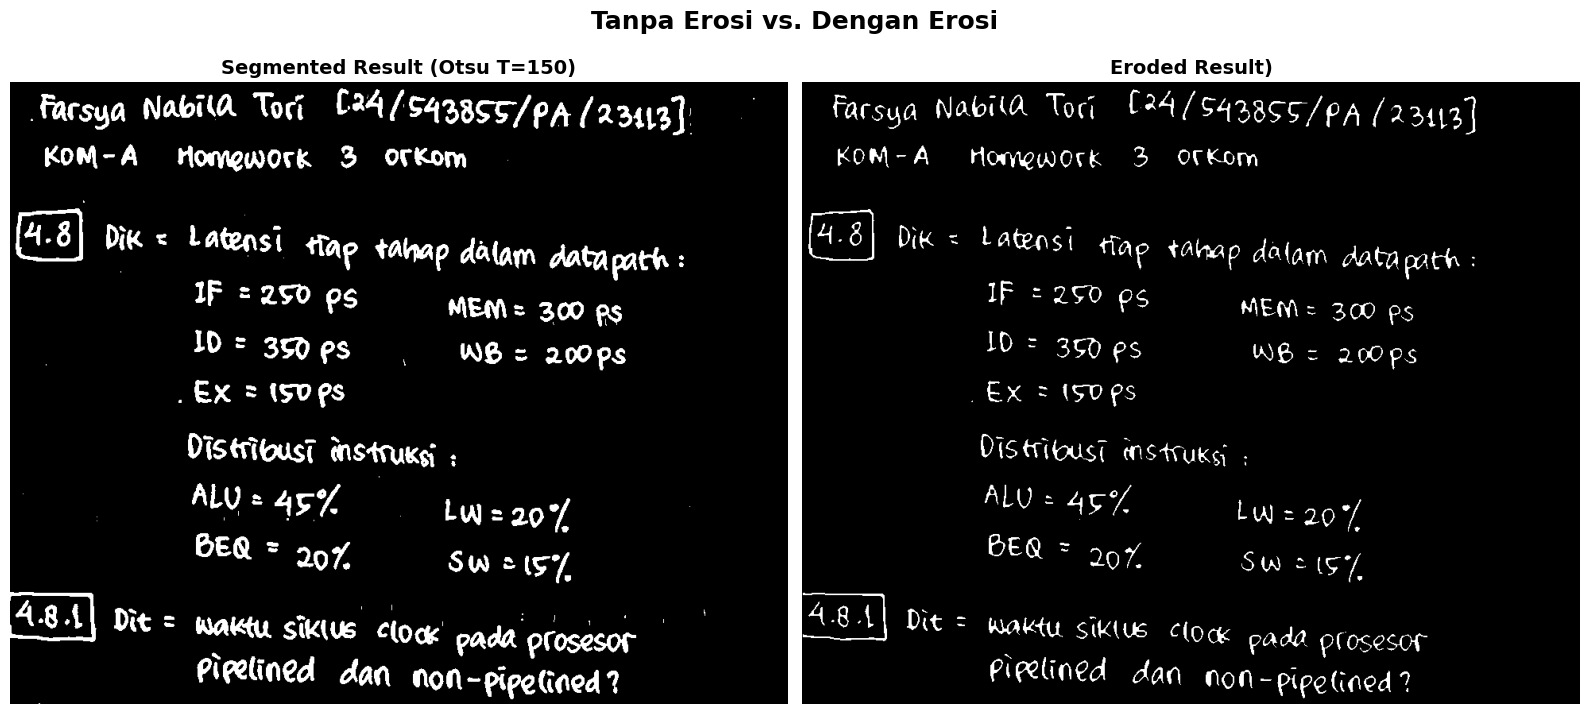

In [ ]:
def manual_erosion(binary_image, kernel):
    rows, cols = binary_image.shape
    k_rows, k_cols = kernel.shape

    pad_rows = k_rows // 2
    pad_cols = k_cols // 2

    boolean_img = binary_image > 0
    padded_img = np.pad(boolean_img, ((pad_rows, pad_rows), (pad_cols, pad_cols)),
                        mode='constant', constant_values=False)
    eroded_img = np.zeros_like(binary_image, dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            window = padded_img[i:i+k_rows, j:j+k_cols]
            if np.all(window[kernel]):
                eroded_img[i, j] = 255
            else:
                eroded_img[i, j] = 0
    return eroded_img

KERNEL_EROSION = np.ones((3, 3), dtype=bool)
if original_color is not None:
    eroded_result = manual_erosion(otsu_segmented_result, KERNEL_EROSION)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    axes[0].imshow(otsu_segmented_result, cmap='gray')
    axes[0].set_title(f'Segmented Result (Otsu T={T_value})', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    axes[1].imshow(eroded_result, cmap='gray')
    axes[1].set_title(f'Eroded Result)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.suptitle('Tanpa Erosi vs. Dengan Erosi', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

#####Hasil Analisis


Berdasarkan output, pengimplementasian erosi dengan kernel square (3x3) ini berhasil menyaring bintik-bintik atau *noise*. Garis tulisan tangan juga menjadi lebih tipis, ramping, dan tajam. Secara keseluruhan, citra menjadi lebih bersih secara visual.

####(2) Dilasi

Ia merupakan operasi *set union* (gabungan). Dalam *binary image*, piksel pusat output akan menjadi *foreground* jika setidaknya satu piksel *foreground* dari kernel tumpang tindih dengan piksel *foreground* di citra.

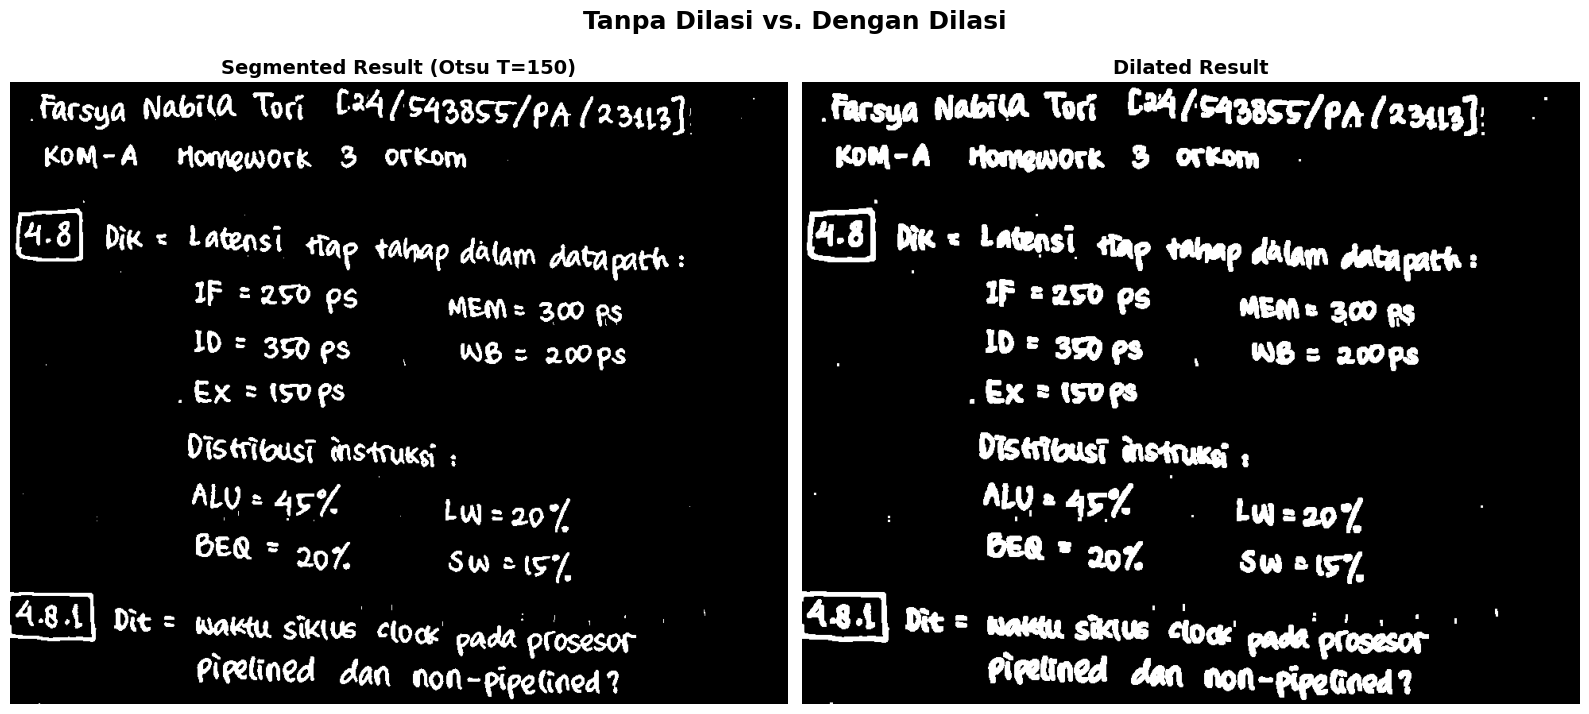

In [ ]:
def manual_dilation(binary_image, kernel):
    rows, cols = binary_image.shape
    k_rows, k_cols = kernel.shape

    pad_rows = k_rows // 2
    pad_cols = k_cols // 2

    boolean_img = binary_image > 0
    padded_img = np.pad(boolean_img, ((pad_rows, pad_rows), (pad_cols, pad_cols)),
                        mode='constant', constant_values=False)
    dilated_img = np.zeros_like(binary_image, dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            window = padded_img[i:i+k_rows, j:j+k_cols]
            if np.any(window[kernel]):
                dilated_img[i, j] = 255
            else:
                dilated_img[i, j] = 0
    return dilated_img

KERNEL_DILATION = np.ones((3, 3), dtype=bool)
if original_color is not None:
    dilated_result = manual_dilation(otsu_segmented_result, KERNEL_DILATION)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    axes[0].imshow(otsu_segmented_result, cmap='gray')
    axes[0].set_title(f'Segmented Result (Otsu T={T_value})', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    axes[1].imshow(dilated_result, cmap='gray')
    axes[1].set_title(f'Dilated Result', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.suptitle('Tanpa Dilasi vs. Dengan Dilasi', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

#####Hasil Analisis

Pengimplementasian dilasi dengan kernel square (3x3) berhasil mencapai tujuannya, yaitu untuk menambah ketebalan pada garis tulisan tangan secara merata. Celah kecil pada angka atau huruf juga menjadi tertutup sehingga karakter terlihat lebih utuh. Selain itu, bintik atau *noise* juga ikut membesar, terlihat pada kemunculan banyaknya bintik putih pada *background.*

####(3) Opening

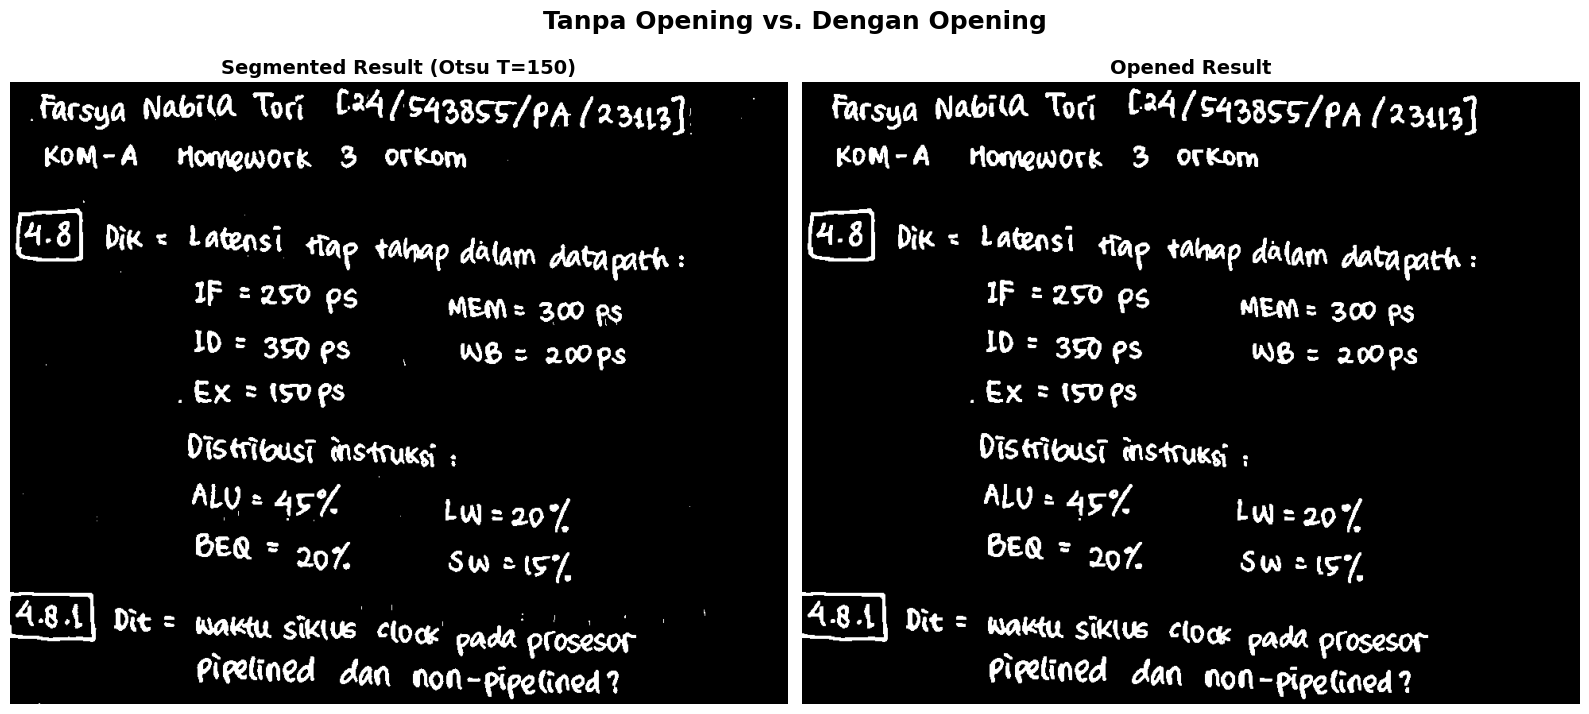

In [ ]:
def manual_opening(binary_image, kernel):
   eroded_result = manual_erosion(otsu_segmented_result, KERNEL_EROSION)
   opened_result = manual_dilation(eroded_result, KERNEL_EROSION)
   return opened_result

if original_color is not None:
    opened_result = manual_dilation(eroded_result, KERNEL_EROSION)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    axes[0].imshow(otsu_segmented_result, cmap='gray')
    axes[0].set_title(f'Segmented Result (Otsu T={T_value})', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    axes[1].imshow(opened_result, cmap='gray')
    axes[1].set_title(f'Opened Result', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.suptitle('Tanpa Opening vs. Dengan Opening', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

#####Hasil Analisis

Operasi Opening (erosi diikuti dilasi) dengan kernel square (3x3) ini berhasil menghilangkan hampir semua bintik putih kecil dari *foreground* tanpa merusak bentuk tulisan tangan secara signifikan. Hasilnya, *background* menjadi lebih bersih, tepi tulisan terlihat lebih halus, garis teks tetap dipertahankan (tidak setipis hasil erosi), dan lebih representatif untuk proses analisis lanjutan. <br> <br>
Optical Character Recognition (OCR) memanfaatkan salah satu *morphological transformation*, yakni Opening untuk meningkatkan akurasi deteksi teks pada citra. Sebab semakin baik kemampuan mengesktrak fitur dari karakter, semakin banyak yang dapat terdeteksi dengan akurasi yang tinggi. <br>
Referensi: https://ejournal.unesa.ac.id/index.php/jinacs/article/download/47260/39603

####(4) Closing

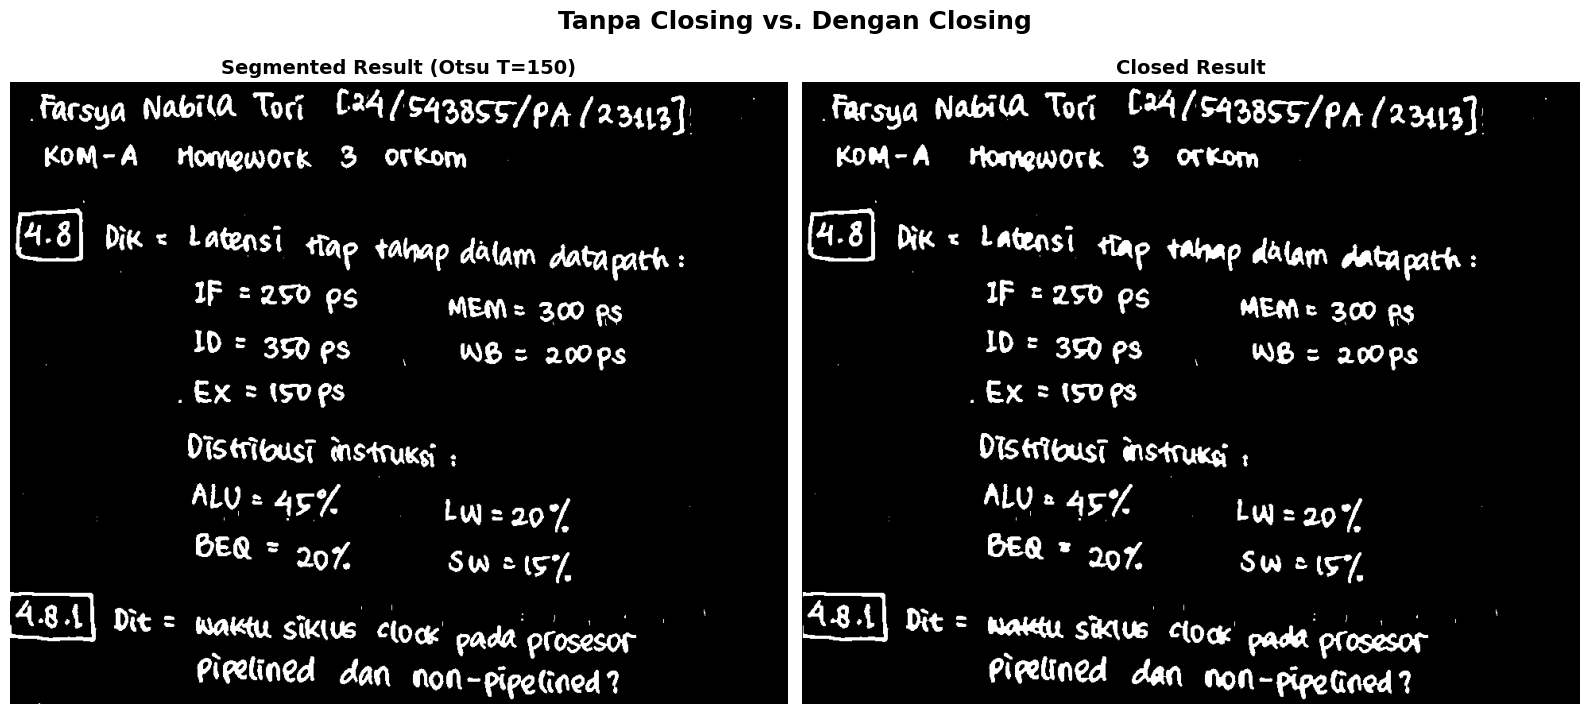

In [ ]:
def manual_closing(binary_image, kernel):
  dilated_result = manual_dilation(otsu_segmented_result, KERNEL_DILATION)
  closed_result = manual_erosion(dilated_result, KERNEL_DILATION)
  return closed_result

if original_color is not None:
  closed_result = manual_closing(otsu_segmented_result, KERNEL_DILATION)

  fig, axes = plt.subplots(1, 2, figsize=(16, 7))
  axes[0].imshow(otsu_segmented_result, cmap='gray')
  axes[0].set_title(f'Segmented Result (Otsu T={T_value})', fontsize=14, fontweight='bold')
  axes[0].axis('off')
  axes[1].imshow(closed_result, cmap='gray')
  axes[1].set_title(f'Closed Result', fontsize=14, fontweight='bold')
  axes[1].axis('off')
  plt.suptitle('Tanpa Closing vs. Dengan Closing', fontsize=18, fontweight='bold', y=1.02)
  plt.tight_layout()
  plt.show()

#####Hasil Analisis

Penggunaan Closing berhasil mengisi dan menutup celah-celah kecil *(filling the hole)* pada *foreground* tanpa mengubah ukuran objek secara drastis. Garis tulisan terlihat lebih berkesinambungan dan utuh, juga sedikit lebih tumpul dan mulus. Selain itu, *noise* yang ada dipertahankan atau sedikit membesar di *background.* <br> <br>
Pada pemrosesan citra medis, seperti MRI/CT Scan, operasi closing digunakan untuk memproses volume, seperti otak (brain volume) untuk menghasilkan batas yang mulus dan volume yang utuh. Sementara itu, dalam konteks analisis data multibeam sonar untuk pemetaan terumbu, closing digunakan untuk memperbaiki grafik yang terputus dalam jaringan, yang merujuk pada pemastian fitur terumbu yang seharusnya terhubung menjadi satu kesatuan yang utuh. <br>
Referensi: <br>
https://www.researchgate.net/publication/323280279_Morphological_Operations_in_Medical_Image_Pre-Processing
<br>
https://www.researchgate.net/figure/Morphological-opening-b-and-closing-c-applied-on-the-binary-image-a-using-a-disk-of_fig4_222517342

####Kesimpulan

Dapat disimpulkan empat peran operasi morfologis sederhana, yakni <br>
**- Erosi:** Berhasil melakukan pengikisan batas dan menghilangkan *noise* atau bintik kecil, tetapi dengan *trade-off* membuat tulisan menjadi terlalu tipis.

**- Dilasi:** Berhasil melakukan perluasan objek dan menghubungkan celah *(gaps)* pada tulisan, tetapi dengan *trade-off* membuat noise juga ikut membesar.

**- Opening:** Kombinasi yang efektif untuk menghilangkan *noise* tanpa terlalu banyak merusak ukuran objek karena dilasi mengimbangi efek erosi.

**- Closing:** Kombinasi yang efektif untuk mengisi celah dan lubang pada *foreground*, mendukung integritas bentuk tulisan.